In [1]:
# Запускать всегда
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [10]:
# Запускать при обучении
# Чтение данных из CSV файла с возможностью объединения датафреймов
df = pd.read_csv('summer-data/neuroattr_10sec_cnt_8_0_1000.csv', delimiter=',')
second_data = pd.read_csv('summer-data/neuroattr_10sec_cnt_8_10001_20000.csv')
df = pd.concat([df, second_data], ignore_index=True)

# Преобразование столбца 'event_time' в формат даты и времени
df['event_time'] = pd.to_datetime(df['event_time'])

# Сортировка датафрейма по столбцу 'event_time'
df = df.sort_values('event_time')

# Извлечение значений столбца 'interval_column' и преобразование в формат numpy массива
interval_column = 'value_interval_10sec'
df = df.dropna(subset=[interval_column]) # Игнорирование строк с пустыми значениями
data = df[interval_column].values.reshape(-1, 1)

# Нормализация данных с использованием MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Преобразование данных в формат torch.Tensor
data = torch.from_numpy(data).double()

In [11]:
# Запускать при обучении
# Определение размера тренировочного набора данных (80% от общего количества данных)
train_size = int(0.8 * len(data))

# Разделение данных на тренировочный и тестовый наборы
train_data = data[:train_size]  # Первые train_size элементов используются для тренировки
test_data = data[train_size:]   # Оставшиеся элементы используются для тестирования

In [2]:
# Запускать всегда
# Определение класса SignalDataset, представляющего пользовательский датасет
class SignalDataset(torch.utils.data.Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        # Получение последовательности длиной sequence_length как входные данные (x)
        x = self.data[idx:idx+self.sequence_length]
        # Получение следующего элемента после последовательности как целевое значение (y)
        y = self.data[idx+self.sequence_length]
        return x, y

In [13]:
# Запускать при обучении
sequence_length = 10 # Определение длины последовательности

# Создание тренировочного датасета на основе тренировочных данных и sequence_length
train_dataset = SignalDataset(train_data, sequence_length)

# Создание DataLoader для тренировочного датасета с указанием размера пакета (batch_size) и перемешиванием данных (shuffle=True)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

In [3]:
# Запускать всегда
# Определение класса AnomalyDetectionModel, представляющего модель обнаружения аномалий
class AnomalyDetectionModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(AnomalyDetectionModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)  # LSTM слой
        self.fc = nn.Linear(hidden_size, output_size)  # Полносвязный слой

    def forward(self, x):
        output, _ = self.lstm(x)  # Прямой проход через LSTM слой
        output = self.fc(output[:, -1, :])  # Применение полносвязного слоя к последнему выходу LSTM
        return output

input_size = 1
hidden_size = 64
output_size = 1

# Создание экземпляра модели AnomalyDetectionModel с указанными размерами входа, скрытого слоя и выхода
model = AnomalyDetectionModel(input_size, hidden_size, output_size)

# Установка типа данных модели на double
model.double()

AnomalyDetectionModel(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [8]:
# Запускать при обучении без создания анимации
num_epochs = 10
learning_rate = 0.001

criterion = nn.MSELoss()  # Определение функции потерь (среднеквадратичная ошибка)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Оптимизатор (Adam) для обновления весов модели

# Цикл обучения модели
for epoch in range(num_epochs):
    for batch_x, batch_y in train_dataloader:
        optimizer.zero_grad()  # Сброс градиентов
        outputs = model(batch_x)  # Прямой проход через модель для получения предсказаний
        loss = criterion(outputs, batch_y)  # Вычисление функции потерь между предсказаниями и целевыми значениями
        loss.backward()  # Обратное распространение ошибки для вычисления градиентов
        optimizer.step()  # Обновление весов модели на основе градиентов

    print(f'Эпоха [{epoch+1}/{num_epochs}], Потери: {loss.item():.6f}')  # Вывод значения функции потерь для текущей эпохи

Эпоха [1/10], Потери: 0.000257
Эпоха [2/10], Потери: 0.002713
Эпоха [3/10], Потери: 0.001769
Эпоха [4/10], Потери: 0.001889
Эпоха [5/10], Потери: 0.000914
Эпоха [6/10], Потери: 0.000340
Эпоха [7/10], Потери: 0.000388
Эпоха [8/10], Потери: 0.006505
Эпоха [9/10], Потери: 0.002381
Эпоха [10/10], Потери: 0.000425


Эпоха [1/10], Потери: 0.000105
Эпоха [2/10], Потери: 0.005021
Эпоха [3/10], Потери: 0.000794
Эпоха [4/10], Потери: 0.000040
Эпоха [5/10], Потери: 0.007002
Эпоха [6/10], Потери: 0.001113
Эпоха [7/10], Потери: 0.004858
Эпоха [8/10], Потери: 0.002254
Эпоха [9/10], Потери: 0.002280
Эпоха [10/10], Потери: 0.000741


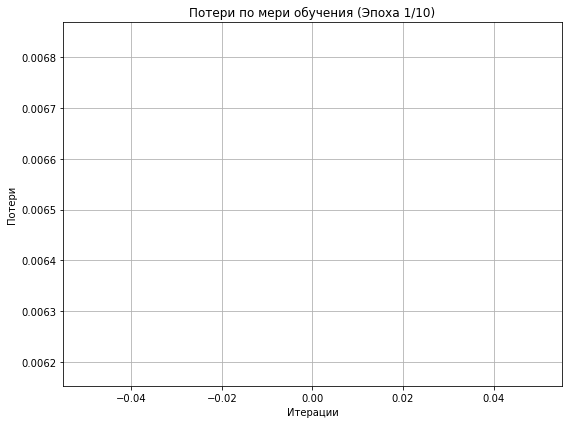

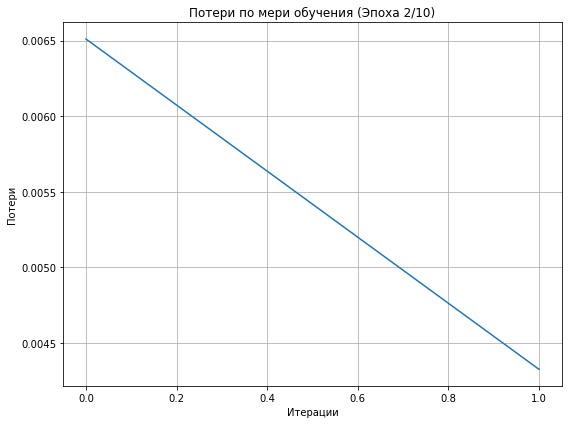

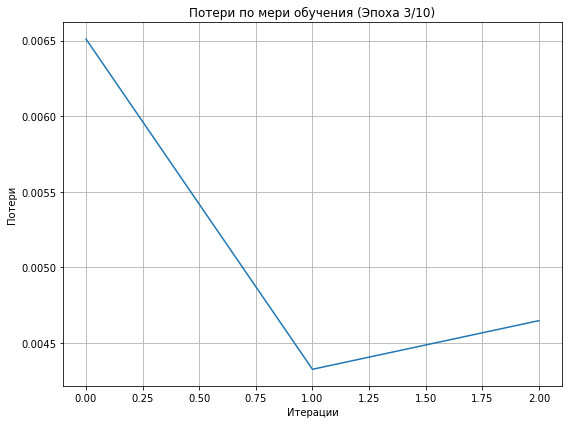

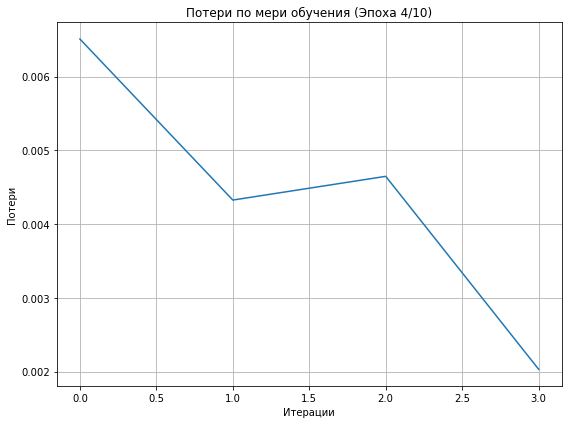

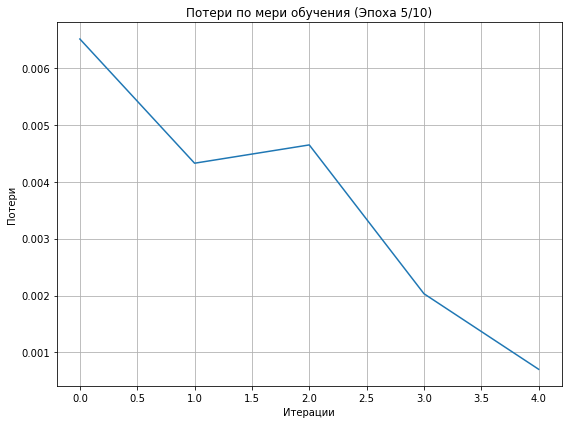

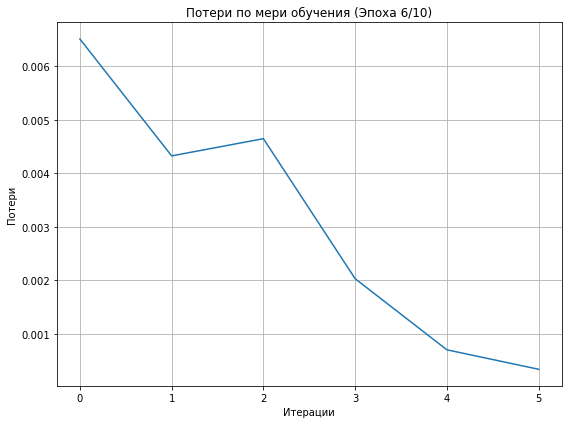

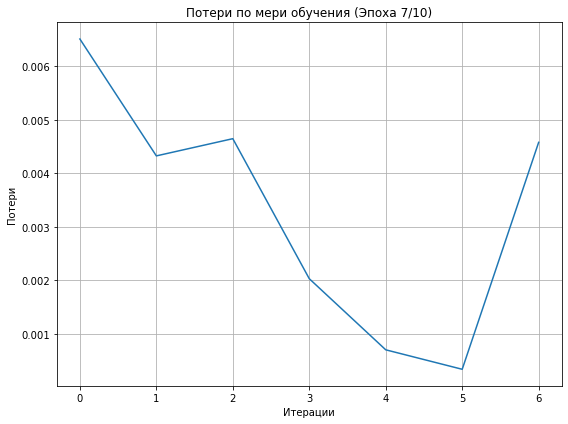

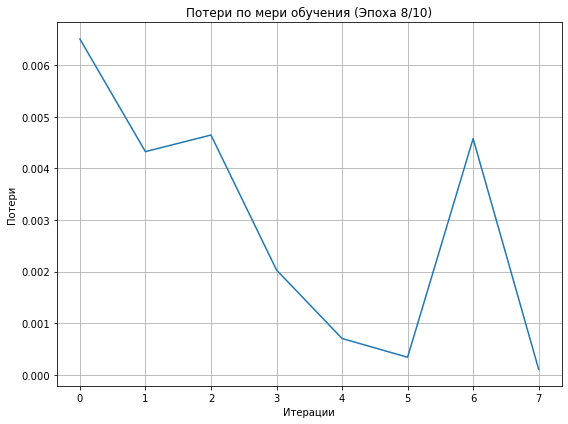

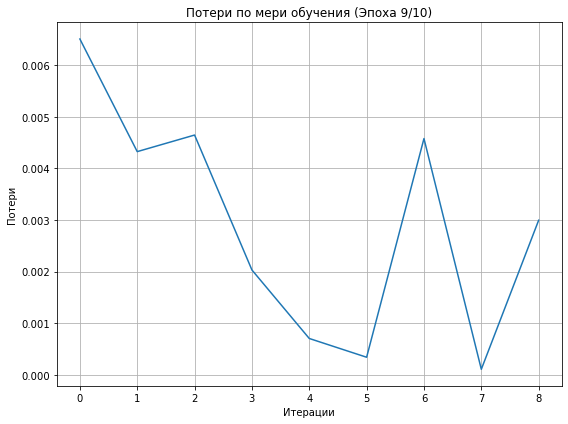

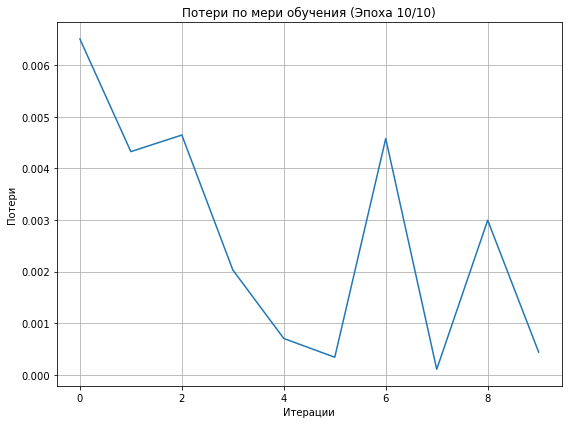

In [15]:
# Запускать при обучении с созданием анимации
import matplotlib.pyplot as plt
import numpy as np
import imageio

num_epochs = 10
learning_rate = 0.001

criterion = nn.MSELoss()  # Определение функции потерь (среднеквадратичная ошибка)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Оптимизатор (Adam) для обновления весов модели

loss_history = []  # Список для сохранения значений функции потерь

# Цикл обучения модели
for epoch in range(num_epochs):
    for batch_x, batch_y in train_dataloader:
        optimizer.zero_grad()  # Сброс градиентов
        outputs = model(batch_x)  # Прямой проход через модель для получения предсказаний
        loss = criterion(outputs, batch_y)  # Вычисление функции потерь между предсказаниями и целевыми значениями
        loss.backward()  # Обратное распространение ошибки для вычисления градиентов
        optimizer.step()  # Обновление весов модели на основе градиентов

        loss_history.append(loss.item())  # Добавление значения функции потерь в список

    print(f'Эпоха [{epoch+1}/{num_epochs}], Потери: {loss.item():.6f}')  # Вывод значения функции потерь для текущей эпохи

# Создание анимации GIF
images = []
for epoch in range(num_epochs):
    plt.figure(figsize=(8, 6))
    plt.plot(np.arange(len(loss_history[:epoch+1])), loss_history[:epoch+1])
    plt.title(f'Потери по мере обучения (Эпоха {epoch+1}/{num_epochs})')
    plt.xlabel('Итерации')
    plt.ylabel('Потери')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'epoch_{epoch+1}.png')
    images.append(imageio.imread(f'epoch_{epoch+1}.png'))

imageio.mimsave('training_animation.gif', images, fps=2)

In [16]:
# Запускать при обучении
# Сохранение весов модели
torch.save(model.state_dict(), 'model_weights.pt')

In [17]:
# Запускать при обучении (необязально)
import torchviz
# Создание случайного входного тензора нужной формы
dummy_input = torch.zeros((1, sequence_length, input_size), dtype=torch.double)
# Визуализация структуры модели
graph = torchviz.make_dot(model(dummy_input), params=dict(model.named_parameters()))
graph.render("anomaly_model_graph", format="png")

'anomaly_model_graph.png'

In [18]:
# Запускать при обучении (необязательно)
# Создание тестового датасета на основе тестовых данных и sequence_length
test_dataset = SignalDataset(test_data, sequence_length)
# Создание DataLoader для тестового датасета с размером пакета 1
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1)

anomaly_threshold = 0.65  # Пороговое значение для определения аномалий

model.eval()  # Переключение модели в режим оценки (evaluation)
anomalies = []  # Список для хранения обнаруженных аномалий

with torch.no_grad():
    for idx, (test_x, test_y) in enumerate(test_dataloader):
        output = model(test_x)  # Получение предсказания модели для тестовых данных
        error = torch.abs(output - test_y)  # Вычисление абсолютной ошибки между предсказанием и целевым значением
        if error > anomaly_threshold:  # Если ошибка превышает пороговое значение, считаем это аномалией
            detection_time = df['event_time'].iloc[train_size + idx + sequence_length].strftime("%Y-%m-%d %H:%M:%S")  # Время обнаружения аномалии
            sequence = scaler.inverse_transform(test_x.squeeze().numpy().reshape(-1, 1))  # Восстановление исходной последовательности
            received_value = scaler.inverse_transform(test_y.numpy()).item()  # Восстановление полученного значения
            expected_value = scaler.inverse_transform(output.numpy()).item()  # Восстановление ожидаемого значения
            anomalies.append((detection_time, sequence, expected_value, received_value))  # Добавление информации об аномалии в список

# Вывод информации об обнаруженных аномалиях
for anomaly in anomalies:
    detection_time = anomaly[0]
    sequence = anomaly[1]
    sequence_str = ', '.join(str(int(value[0])) for value in sequence)  # Преобразование последовательности в строку
    expected_value = anomaly[2]
    received_value = int(anomaly[3])
    print(f'Время: {detection_time}, Последовательность: [{sequence_str}], Ожидалось: {expected_value}, Было получено: {received_value}')

Время: 2022-04-17 03:08:00, Последовательность: [0, 0, 0, 0, 6, 6, 13, 13, 7, 0], Ожидалось: 3.499590046294839, Было получено: 36
Время: 2022-04-17 03:11:00, Последовательность: [0, 14, 14, 0, 0, 14, 13, 0, 0, 0], Ожидалось: 2.6012557753107206, Было получено: 33
Время: 2022-04-17 03:23:00, Последовательность: [0, 0, 0, 0, 5, 18, 3, 0, 2, 0], Ожидалось: 2.494236370945766, Было получено: 33
Время: 2022-04-17 07:44:30, Последовательность: [0, 0, 0, 0, 15, 0, 0, 0, 12, 0], Ожидалось: -0.3100270369452651, Было получено: 31
Время: 2022-04-17 07:50:50, Последовательность: [0, 0, 13, 13, 0, 0, 0, 0, 0, 15], Ожидалось: 5.487716191355998, Было получено: 42
Время: 2022-04-17 08:00:40, Последовательность: [12, 29, 0, 0, 0, 0, 0, 0, 0, 17], Ожидалось: 5.843230768188836, Было получено: 45
Время: 2022-04-17 08:25:00, Последовательность: [0, 0, 0, 0, 13, 0, 12, 14, 28, 2], Ожидалось: -0.3695926301600331, Было получено: 30


Время: 2022-04-17 08:50:40, Последовательность: [0, 0, 0, 1, 0, 0, 17, 15, 0, 30], Ожидалось: 13.379953578646234, Было получено: 32
Время: 2022-04-17 08:53:00, Последовательность: [4, 0, 0, 3, 0, 13, 0, 0, 0, 2], Ожидалось: 2.4060068886139927, Было получено: 16
Время: 2022-04-17 08:55:40, Последовательность: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], Ожидалось: 0.6401206277429696, Было получено: 28
Время: 2022-04-17 08:56:20, Последовательность: [0, 0, 0, 0, 0, 0, 28, 0, 0, 0], Ожидалось: 0.9698506851379345, Было получено: 26
Время: 2022-04-17 08:56:30, Последовательность: [0, 0, 0, 0, 0, 28, 0, 0, 0, 26], Ожидалось: 13.02048648728309, Было получено: 0
Время: 2022-04-17 08:57:00, Последовательность: [0, 0, 28, 0, 0, 0, 26, 0, 0, 0], Ожидалось: 0.7129781919551572, Было получено: 16
Время: 2022-04-17 08:59:10, Последовательность: [2, 0, 0, 3, 0, 12, 0, 0, 0, 13], Ожидалось: 5.797753215828713, Было получено: 28
Время: 2022-04-17 08:59:30, Последовательность: [0, 3, 0, 12, 0, 0, 0, 13, 28, 0], Ожидал

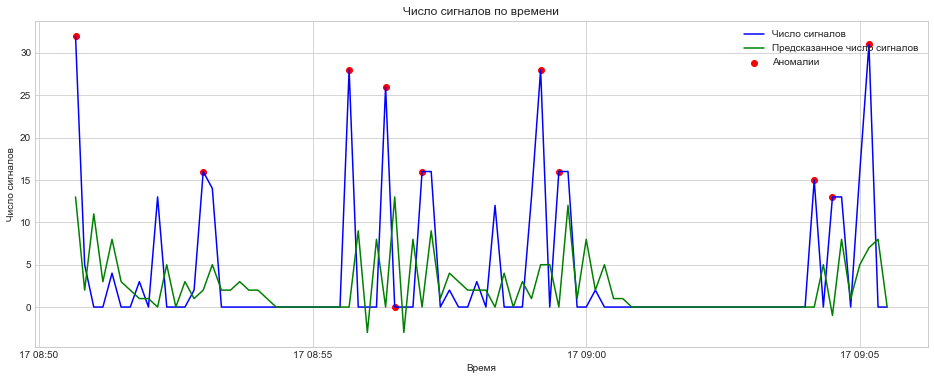

In [42]:
# Запускать при работе с сохраненной моделью
import matplotlib.pyplot as plt

new_df = pd.read_csv('summer-data/neuroattr_10sec_cnt_8_20001_30000.csv', delimiter=',')  # Чтение данных из нового CSV файла
new_df = new_df.head(100) # Обрезка входных данных

new_df['event_time'] = pd.to_datetime(new_df['event_time'])  # Преобразование столбца 'event_time' в формат даты и времени

new_df = new_df.sort_values('event_time')  # Сортировка датафрейма по столбцу 'event_time'

new_interval_column = 'value_interval_10sec'
new_df = new_df.dropna(subset=[new_interval_column])  # Игнорирование строк с пустыми значениями
new_data = new_df[new_interval_column].values.reshape(-1, 1)  # Извлечение значений столбца 'value_interval_10sec'

# Нормализация данных с использованием MinMaxScaler
scaler = MinMaxScaler()
new_data = scaler.fit_transform(new_data)  # Нормализация новых данных
new_data = torch.from_numpy(new_data).double()  # Преобразование новых данных в формат torch.Tensor

new_anomaly_threshold = 0.65  # Пороговое значение для определения новых аномалий
new_sequence_length = 10  # Длина последовательности новых данных

new_dataset = SignalDataset(new_data, new_sequence_length)  # Создание нового датасета на основе новых данных и длины последовательности
new_dataloader = torch.utils.data.DataLoader(new_dataset, batch_size=1)  # Создание DataLoader для нового датасета

# Создание нового экземпляра модели
new_model = AnomalyDetectionModel(input_size, hidden_size, output_size)

# Загрузка сохраненных весов модели
new_model.load_state_dict(torch.load('model_weights.pt'))
new_model.double()
new_model.eval()

# Списки данных для создания графика
timestamps = []
num_signals = []
predicted_signals = []
anomaly_timestamps = []
anomaly_signals = []

# Список для хранения обнаруженных новых аномалий
anomalies = []

with torch.no_grad():
    for idx, (test_x, test_y) in enumerate(new_dataloader):
        output = new_model(test_x)  # Получение предсказания новой модели для новых тестовых данных
        error = torch.abs(output - test_y)  # Вычисление абсолютной ошибки между предсказанием и целевым значением
        received_value = scaler.inverse_transform(test_y.numpy()).item()  # Восстановление полученного значения
        expected_value = scaler.inverse_transform(output.numpy()).item()  # Восстановление ожидаемого значения
        timestamps.append(new_df['event_time'].iloc[idx + new_sequence_length]) # Время получения сигнала
        num_signals.append(int(received_value)) # Добавление в список полученного числа сигналов
        predicted_signals.append(int(expected_value)) # Добавление в список предсказанного числа сигналов
        if error > new_anomaly_threshold:  # Если ошибка превышает пороговое значение, считаем это новой аномалией
            detection_time = new_df['event_time'].iloc[idx + new_sequence_length].strftime("%Y-%m-%d %H:%M:%S")  # Время обнаружения новой аномалии
            sequence = scaler.inverse_transform(test_x.squeeze().numpy().reshape(-1, 1))  # Восстановление исходной последовательности новых данных
            anomalies.append((detection_time, sequence, expected_value, received_value))  # Добавление информации о новой аномалии в список
            anomaly_timestamps.append(detection_time) # Время обнаружения аномалии
            anomaly_signals.append(int(received_value)) # Число сигналов в аномалии

# Вывод информации об обнаруженных новых аномалиях
for anomaly in anomalies:
    detection_time = anomaly[0]
    sequence = anomaly[1]
    sequence_str = ', '.join(str(int(value[0])) for value in sequence)  # Преобразование последовательности в строку
    expected_value = anomaly[2]
    received_value = int(anomaly[3])
    print(f'Время: {detection_time}, Последовательность: [{sequence_str}], Ожидалось: {expected_value}, Было получено: {received_value}')

# Создание графика числа сигналов
plt.figure(figsize=(16, 6))
plt.plot(timestamps, num_signals, color='blue', label='Число сигналов')
plt.plot(timestamps, predicted_signals, color='green', label='Предсказанное число сигналов')
plt.scatter(anomaly_timestamps, anomaly_signals, color='red', label='Аномалии')
plt.xlabel('Время')
plt.ylabel('Число сигналов')
plt.title('Число сигналов по времени')
plt.legend()
plt.show()

C:\Users\Daniil\AppData\Local\Temp\ipykernel_14404\491748992.py:6: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  s = pd.read_csv('summer-data/neuroattr_10sec_cnt_8_20001_30000.csv', index_col="event_time", parse_dates=True, squeeze=True)


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

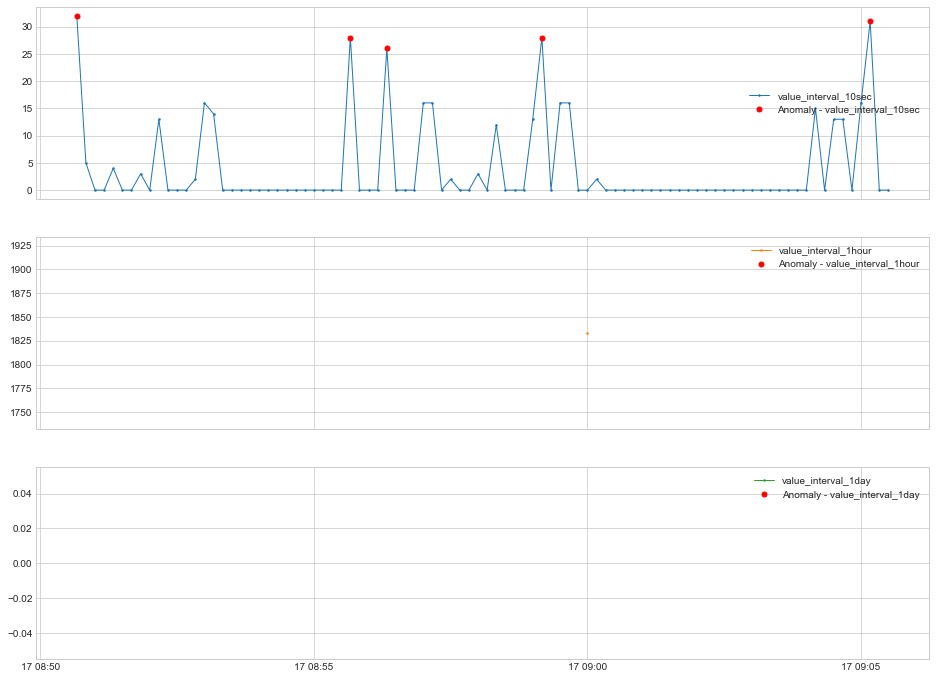

In [49]:
from adtk.detector import InterQuartileRangeAD
from adtk.visualization import plot
from adtk.data import validate_series
import pandas as pd

s = pd.read_csv('summer-data/neuroattr_10sec_cnt_8_20001_30000.csv', index_col="event_time", parse_dates=True, squeeze=True)
s = validate_series(s)
iqr_ad = InterQuartileRangeAD(c=3) # Создание объёкта класса с c=3
alter_anomalies = iqr_ad.fit_detect(s) # Поиск аномалий
trimmed_s = s.iloc[10:100]  # Обрезка данных
trimmed_anomalies = alter_anomalies.loc[trimmed_s.index]  # Обрезека последовательности аномалий

# Вывод графика
plot(trimmed_s, anomaly=trimmed_anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker")

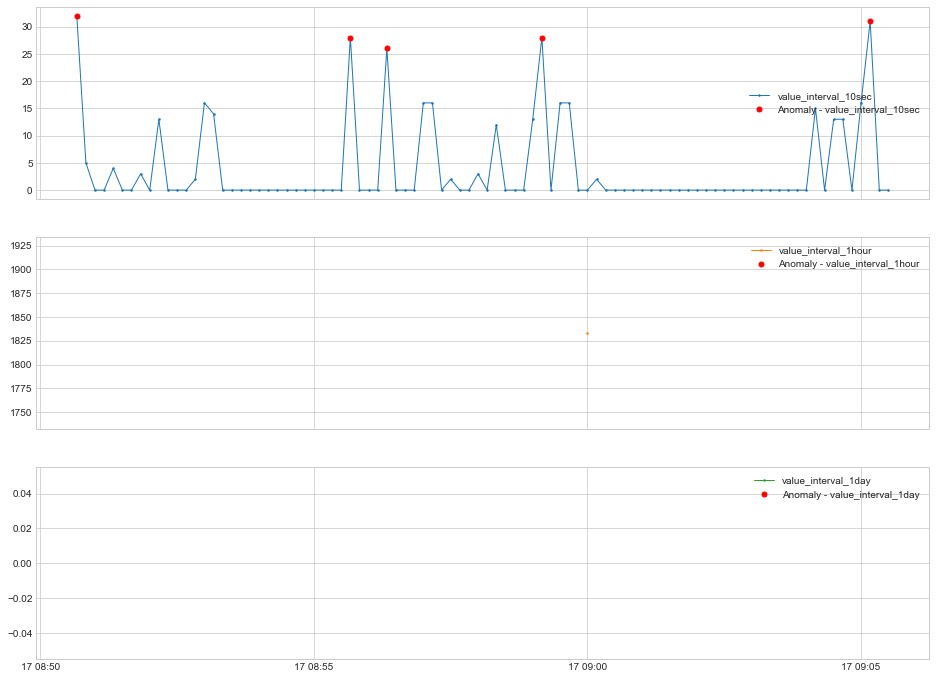

In [57]:
from adtk.detector import GeneralizedESDTestAD
esd_ad = GeneralizedESDTestAD(alpha=1.55) # Создание объёкта класса с alpha = 1.55
# alpha 23 дает существенно изменение числа точек
alter_anomalies = esd_ad.fit_detect(s) # Поиск аномалий
trimmed_s = s.iloc[10:100]  # Обрезка данных
trimmed_anomalies = alter_anomalies.loc[trimmed_s.index]  # Обрезека последовательности аномалий

# Вывод графика
plot(trimmed_s, anomaly=trimmed_anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");